In [14]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

import yaml
import hashlib

In [137]:
class SymbolicDiscreteDamage:
    def __init__(self, state, matpar, 
                 name = "discrete generalised damage",
                 slug = "general damage"):
        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug

    def _s(self, αi):
        s = sp.Function('s')
        # s = 1/self._a(αi)
        return s(αi)

    def _a(self, αi):
        γ = self.matpar["γ"]
        a = sp.Function('a')
        return a(αi)
    
    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        e = state["e"]
        _α = state["α"]
        # _w1 = matpar["w1"]
        _E0 = self.matpar["E0"]
        _N = self.matpar["N"]
    
        return sum([1./2. * E0 * self._a(α[i]) * e[i]**2 for i in range(len(α))])

    def _w(self, αi):
        w = sp.Function('w')

        return w(αi)

    def _damage(self, state):
        _α = state["α"]
        _w1 = self.matpar["w1"]

        _N = self.matpar["N"]

        return sum([_w1 * self._w(_α[i]) for i in range(len(_α))]) 
        # return _w1 * self._w(_α)


    # Explicit expressions
    def w(self, αi):
        return αi

    def a(self, αi):
        γ = self.matpar["γ"]

        return (1 - self._w(αi)) / ((γ-1) * self._w(αi) + 1)

    def s(self, αi):

        return 1. / self.a(αi)


    def __str__(self):
     return self.str


In [109]:
class ModelAnalysis:
    """Helper class to analyse (stability) properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        _state = self.state
        self.matpar = model.matpar

        _β = sp.symbols('β')
        _e = sp.symbols('e')
        self._β = _β
        self._e = _e
        
        self._s = model._s(_β)
        self._sp = sp.diff(self._s, _β, 1)
        self._spp = sp.diff(self._s, _β, 2)

        self._a = model._a(_β)
        self._ap = sp.diff(self._a, _β, 1)
        self._app = sp.diff(self._a, _β, 2)

        self._w = model._w(_β)
        self._wp = sp.diff(self._w, _β)
        self._wpp = sp.diff(self._w, _β, 2)

        self.criterion()


    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state
        x = sp.symbols('x')
        t, L, N =  sp.symbols('t L N')

        β = self._β
        e = self._e

        _u0 = t*x/L
        _e0 = t/L
        _alpha0 = 0

        _homogeneous_damage = {a: β for a in state["α"]}
        _homogeneous_strain = {ε: e for ε in state["e"]}
        _sound = {a: 0 for a in state["α"]}

        _crit = sp.diff(
            model.energy(state)                 \
                .subs(_homogeneous_damage)      \
                .subs(_homogeneous_strain), β)  \
                .subs({e: _e0, β: _alpha0})    

        self.crit = 1/N * _crit

        return self.crit

    def critical_load(self, matpar = {}):
        """Critical load"""
        _a = sp.Function('a')
        _w = sp.Function('w')
        t = sp.symbols('t')

        criterion = self.crit           \
            .replace(_a, self.model.a)  \
            .replace(_w, self.model.w)

        tc = sp.solve(criterion, t)
        
        if matpar:
            tc = [_tc.subs(matpar) for _tc in tc if _tc.subs(matpar).is_positive]
        
        return tc, criterion


    def _equilirbrium_e(self):
        state = self.state
        t, L, N =  sp.symbols('t L N')
        _S = sum([self.model._s(αi) for αi in state["α"]])

        _e = [(N*t/L * self.model._s(αi) / _S).simplify() \
                    for αi in state["α"]]

        return _e
    
    def energy_fc_alpha(self):
        _ei = self._equilirbrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        
        return self.model.energy(state).subs(equilibrium_subs)


    def _state_split(self, m, state, matpar):
        """Split the state into homogeneous and bifurcated parts"""

        assert m < matpar[N]

        _bif_α = [state["α"][k+1] for k in range(m)]
        _bif_e = [state["e"][k+1] for k in range(m)]

        _homo_α = set(state["α"]) - set(_bif_α)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif_α, _homo_α, _bif_e, _homo_e

    def _state_homog_substitutions(self, state, matpar):
        """Substitutions for the homogeneous state"""
        αt = sp.symbols('α_t')
        et = sp.symbols('e_t')

        _subs_αh = {a: αt for a in state["α"]}
        _subs_eh = {e: et for e in state["e"]}

        return _subs_αh, _subs_eh


    def _state_bifurcation_substitutions(self, m, state, matpar):
        """Computes substitutions for bifurcated states"""

        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)
        _αb = sp.symbols("a^*")
        _eb = sp.symbols("e^*")
        αt = sp.symbols('α_t')
        et = sp.symbols('e_t')

        _subs_αb = {a: _αb for a in _bif}
        _subs_eb = {e: _eb for e in _bif_e}

        _subs_αt = {a: αt for a in _homo}
        _subs_et = {e: et for e in _homo_e}

        return {**_subs_αb, **_subs_αt}, {**_subs_eb, **_subs_et}


    def homogeneous_α(self, state, matpar = {}):
        """Solves the (homogeneous) evolution law for damage"""
        αt = sp.symbols('α_t')
        state = self.state
        
        if matpar:
            return [sol.subs(matpar) for sol in \
                    list(map(sp.simplify, sp.solve(self.evo_α(state, matpar), αt)))]
        else:
            return list(map(sp.simplify, sp.solve(self.evo_α(state), αt)))

    def homogeneous_damage(self, state, matpar= {}):
        idx = self.positive_solution_wrt_t(matpar)[0]
        _alpha = self.homogeneous_α(matpar)[idx].subs(matpar)
        tc = model.critical_load(matpar)[0][0]
        t = sp.symbols('t')

        # tc = self.critical_load(matpar)
        alpha = sp.Piecewise(
            (_alpha, t >= tc),
            (0, t < tc)
        )

        return alpha
    #     stress_alpha = sp.Piecewise(
        # (sp.sqrt(2 * self._wp / self._sp).subs({α: _ah}), t >= _tc),
        # (sp.diff(_u0, x).subs(_matpar), t < _tc))

    def evo_α(self, state, matpar = {}):
        """Evolution law for damage"""
        αt = sp.symbols('α_t')
        _a = sp.Function('a')
        _w = sp.Function('w')

        subs_homog_α, _ =  self._state_homog_substitutions(state, matpar)

        return sp.diff(self.energy_fc_alpha().subs(subs_homog_α), αt)                   \
            .replace(_a, self.model.a)                  \
            .replace(_w, self.model.w)                  \
            .doit().simplify()

    def positive_solution_wrt_t(self, _matpar = {}):
        idx = np.where(np.array([sp.diff(eq, sp.symbols('t')).subs(_matpar) for eq in self.homogeneous_α(_matpar)]) > 0)[0]
        return idx

In [138]:
N = sp.symbols("N")
t = sp.symbols('t')
_a = sp.Function('a')
_w = sp.Function('w')

_N = 2

γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')

u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
_α = sp.symbols("α")



β = sp.symbols('β')

state = {"u": u, "α": α, "e": e}
_matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}

atls = SymbolicDiscreteDamage(state, matpar)

model = ModelAnalysis(atls)
model.criterion()


(1.0*E0*t**2*Subs(Derivative(a(β), β), β, 0)/L**2 + 2*w1*Subs(Derivative(w(β), β), β, 0))/N

In [139]:
(ModelAnalysis(atls).criterion()  \
    .replace(_a, model.model.a )    \
    .replace(_w, model.model.w).doit()).simplify()

-1.0*E0*t**2*γ/(L**2*N) + 2*w1/N

In [140]:
tc, criterion = model.critical_load(_matpar)
tc

[0.707106781186548*sqrt(2)]

In [141]:
model._state_homog_substitutions(state, matpar)

({α1: α_t, α2: α_t}, {e1: e_t, e2: e_t})

In [142]:
model._equilirbrium_e()

[N*t*s(α1)/(L*(s(α1) + s(α2))), N*t*s(α2)/(L*(s(α1) + s(α2)))]

In [143]:
model.energy_fc_alpha()

0.5*E0*N**2*t**2*a(α1)*s(α1)**2/(L**2*(s(α1) + s(α2))**2) + 0.5*E0*N**2*t**2*a(α2)*s(α2)**2/(L**2*(s(α1) + s(α2))**2) + w1*w(α1) + w1*w(α2)

In [144]:
subs_homog_α, _ =  model._state_homog_substitutions(state, matpar)
subs_homog_α

{α1: α_t, α2: α_t}

In [145]:
model.energy_fc_alpha().subs(subs_homog_α)

0.25*E0*N**2*t**2*a(α_t)/L**2 + 2*w1*w(α_t)

In [146]:
(model.energy_fc_alpha().subs(subs_homog_α)/_N).subs(_matpar)

0.5*t**2*a(α_t) + w(α_t)

In [147]:
_a = sp.Function('a')
_w = sp.Function('w')
_s = sp.Function('s')


In [148]:
_s = 1/_a(_α)

In [149]:
_s

1/a(α)

$$
\begin{aligned}
\mathcal E_N (e, \alpha) &=  E_0\sum_{i=0}^N \frac{1}{2}    a(\alpha_i)  e_i^2  + \sum_{i=0}^N {w_1}w(\alpha_i) \\
\tilde {\mathcal E}_N (u, \alpha) &=  E_0 N\sum_{i=0}^N \frac{1}{2}  a(\alpha_i)  (u_i-u_{i-1})^2  + \frac{w_1}{N} \sum_{i=0}^N w(\alpha_i) 
\end{aligned}
$$

In [150]:
# Keeping track of both symboilic and explicit expressions

atls._s(α[0]), atls.s(α[0])

(s(α1), 1.0*((γ - 1)*w(α1) + 1)/(1 - w(α1)))

In [151]:
atls.energy(state)

0.5*E0*e1**2*a(α1) + 0.5*E0*e2**2*a(α2) + w1*w(α1) + w1*w(α2)

In [152]:
model.model.energy(state)

# _homogeneous_damage = {a: β for a in state["α"]}
# _homogeneous_strain = {e: model._e for e in state["e"]}
# _homogeneous_damage, _homogeneous_strain


0.5*E0*e1**2*a(α1) + 0.5*E0*e2**2*a(α2) + w1*w(α1) + w1*w(α2)

In [153]:
sp.diff(model.model.a(_α)       \
        .replace(_w, model.model.w), 
    _α)                         \
        .subs({_α: 0}).doit()

-γ

In [154]:
_homogeneous = {a: β for a in state["α"]}
_sound = {a: 0 for a in state["α"]}

In [155]:
_sound, _homogeneous

({α1: 0, α2: 0}, {α1: β, α2: β})

In [156]:
sp.diff(atls.energy(state).subs(_homogeneous), β).simplify()

0.5*E0*e1**2*Derivative(a(β), β) + 0.5*E0*e2**2*Derivative(a(β), β) + 2*w1*Derivative(w(β), β)

## Model Analysis

- (constitutive assumptions)
- equilibrium
- homogeneous solution
- homogeneous energy
- bifurcations
- stability

In [157]:
atls = SymbolicDiscreteDamage(state, matpar)
model = ModelAnalysis(atls)
(model.criterion()).subs(_matpar)

0.5*t**2*Subs(Derivative(a(β), β), β, 0) + Subs(Derivative(w(β), β), β, 0)

### homogeneous solution

In [158]:
_ei = model._equilirbrium_e()
# state = model.state
equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
# 
# return self.model.energy(state).subs(equilibrium_subs)
# _ei, state, 
equilibrium_subs

{e1: N*t*s(α1)/(L*(s(α1) + s(α2))), e2: N*t*s(α2)/(L*(s(α1) + s(α2)))}

In [159]:
model.energy_fc_alpha() 
# \
# .subs(subs_homog_α)

0.5*E0*N**2*t**2*a(α1)*s(α1)**2/(L**2*(s(α1) + s(α2))**2) + 0.5*E0*N**2*t**2*a(α2)*s(α2)**2/(L**2*(s(α1) + s(α2))**2) + w1*w(α1) + w1*w(α2)

In [160]:
idx = model.positive_solution_wrt_t(_matpar)[0]

In [161]:
sp.simplify(model.homogeneous_α(_matpar)[idx]).subs(_matpar)

0.707106781186548*sqrt(2)*t - 1.0

### Plots of homogeneous response

In [162]:
subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state, _matpar)

# Substitutions to compute homogeneous solutions
subs_homog_α, subs_homog_e

({α1: α_t, α2: α_t}, {e1: e_t, e2: e_t})

In [163]:
evos = [evo.subs(_matpar) for evo in model.homogeneous_α(_matpar)]
evos[idx].subs(_matpar)

0.707106781186548*sqrt(2)*t - 1.0

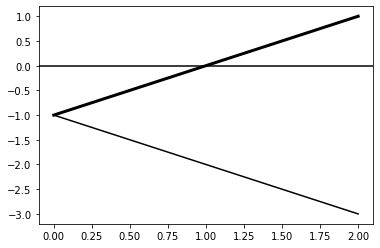

In [164]:
evos = [evo.subs(_matpar) for evo in model.homogeneous_α(_matpar)]
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)
evo_x = evos[idx].subs(_matpar)
for alphas in evos:
    _f = sp.lambdify(t, alphas.subs(_matpar), 'numpy')
    plt.plot(_loads, _f(_loads), c='k')

_f = sp.lambdify(t, evo_x, 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)


plt.axhline(0, c='k')

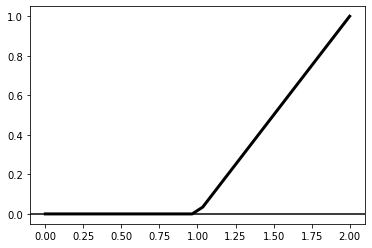

In [166]:
alpha = model.homogeneous_damage(state, _matpar)

_f = sp.lambdify(t, alpha.subs(_matpar), 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)

plt.axhline(0, c='k')

Text(0.5, 0, 't')

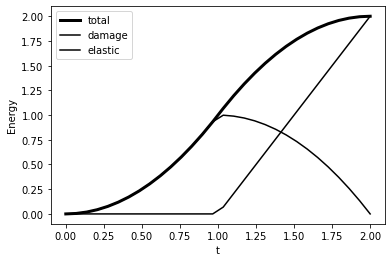

In [169]:
_en = model.energy_fc_alpha().subs(_homogeneous).subs(_matpar) \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)          \
    .subs({sp.symbols('β'): alpha})

_energy_damage = model.model._damage(state).subs(_homogeneous).subs(_matpar) \
            .replace(_w, model.model.w)  \
            .subs({sp.symbols('β'): alpha})

_f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
_f1 = sp.lambdify(t, _energy_damage, 'numpy')
plt.plot(_loads, _f(_loads), c='k', label='total', lw=3)
plt.plot(_loads, _f1(_loads), c='k', label='damage')
plt.plot(_loads, _f(_loads)-_f1(_loads), c='k', label='elastic')

plt.legend()
plt.ylabel('Energy')
plt.xlabel('t')

### Bifurcations

Compute bifurcated solutions with $m$ damaging springs out of the available $N$, with $m<N$

In [254]:
atls = SymbolicDiscreteDamage(state, matpar)
model = ModelAnalysis(atls)
model.criterion().subs(_matpar)

0.5*t**2*Subs(Derivative(a(β), β), β, 0) + Subs(Derivative(w(β), β), β, 0)

In [255]:
# we bifurcate m springs

m = 1

assert m < _matpar[N]

In [256]:
bif_α, homo_α, bif_e, homo_e = model._state_split(m, state, _matpar)
print(f'set of bifurcated springs {bif_α}')
print(f'set of homogeneous springs {homo_α}')

set of bifurcated springs [α2]
set of homogeneous springs {α1, α3}


In [257]:
subs_bif_α, subs_bif_e =  model._state_bifurcation_substitutions(m, state, _matpar)

In [258]:
# substitutions for damage 
subs_bif_α

{α2: a^*, α1: α_t, α3: α_t}

In [259]:
# substitutions for strain

subs_bif_e

{e2: e^*, e3: e_t, e1: e_t}

In [260]:
model.energy_fc_alpha()

0.5*E0*N**2*t**2*a(α1)*s(α1)**2/(L**2*(s(α1) + s(α2) + s(α3))**2) + 0.5*E0*N**2*t**2*a(α2)*s(α2)**2/(L**2*(s(α1) + s(α2) + s(α3))**2) + 0.5*E0*N**2*t**2*a(α3)*s(α3)**2/(L**2*(s(α1) + s(α2) + s(α3))**2) + w1*w(α1) + w1*w(α2) + w1*w(α3)

In [261]:
# The energy of the bifurcated system

_en_alpha_bifurcations = model.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})
_en_alpha_bifurcations  \
            .replace(_a, model.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)          \
            

a^* + 2.25*t**2/(1 + 0.5*(a^* + 1)/(1 - a^*))**2 + 1.125*t**2*(a^* + 1)/((1 - a^*)*(1 + 0.5*(a^* + 1)/(1 - a^*))**2)

In [262]:
sp.simplify(_en_alpha_bifurcations) 

(1.0*E0*N**2*t**2*a(0)*s(0)**2 + 0.5*E0*N**2*t**2*a(a^*)*s(a^*)**2 + L**2*w1*(2*s(0) + s(a^*))**2*(2*w(0) + w(a^*)))/(L**2*(2*s(0) + s(a^*))**2)

In [263]:
sym_en_alpha_bifurcations = sp.simplify(_en_alpha_bifurcations)      \
            .replace(_a, model.model.a)  \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)          \
            .doit()

sym_en_alpha_bifurcations

0.25*(4.0*a^**(1 + 0.5*(a^* + 1)/(1 - a^*))**2 + 9.0*t**2 + 4.5*t**2*(a^* + 1)/(1 - a^*))/(1 + 0.5*(a^* + 1)/(1 - a^*))**2

In [264]:

# The derivative of the energy in the direction of bifurcations, 
# computed for the model at hand, for the bifurcated solutions 

_bif_crit = sp.diff(
    sym_en_alpha_bifurcations, sp.symbols("a^*")
    )

sp.simplify(_bif_crit)

(0.037037037037037*a^***2 - 0.222222222222222*a^* - 0.333333333333333*t**2 + 0.333333333333333)/(0.037037037037037*a^***2 - 0.222222222222222*a^* + 0.333333333333333)

In [265]:
_bif_crit.factor(sp.symbols("a^*")), 

(1.0*(1.0*a^* - 1.0)*(0.333333333333333*a^* - 1.0*t - 1.0)*(0.333333333333333*a^* + 1.0*t - 1.0)/((0.333333333333333*a^* - 1.0)**2*(a^* - 1)),)

In [266]:
bif_evos = sp.solve(_bif_crit, sp.symbols("a^*"))
bif_evos

[3.0 - 3.0*t, 3.0*t + 3.0]

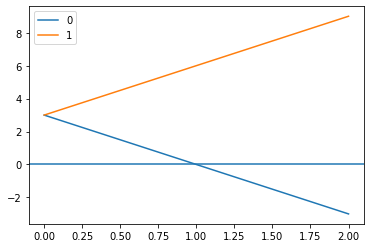

In [267]:
# bif_evos = [evo.subs(_matpar) for evo in model.homogeneous_α(_matpar)]
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)

for i, alphas in enumerate(bif_evos):
    _f = sp.lambdify(t, alphas.subs(_matpar), 'numpy')
    plt.plot(_loads, _f(_loads), label=i)

plt.legend()
plt.axhline(0)

In [268]:
_en_bifurcated = _en_alpha_bifurcations.subs(sp.symbols("a^*"), bif_evos[1].subs(_matpar))   \
            .replace(_a, model.model.a)  \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)  \
            .subs(_matpar)          \
            .doit()

sp.simplify(_en_bifurcated)

4.5*t**2 + 6.0*t + 3.0

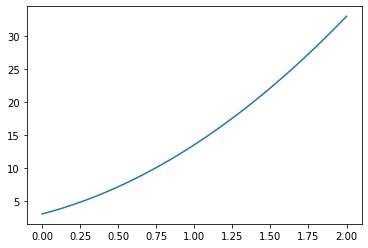

In [269]:
_f = sp.lambdify(t, sp.simplify(_en_bifurcated), 'numpy')
plt.plot(_loads, _f(_loads), label='en')
